In [6]:
import torch
from torch.utils import data  # 获取迭代数据
from torch.autograd import Variable  # 获取变量
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import mnist  # 获取数据集
import matplotlib.pyplot as plt
from torch import nn

import os

path = r"./model"
if not os.path.exists(path):
    os.mkdir(path)


def get_dataloader(mode):
    """
    获取数据集加载
    :param mode:
    :return:
    """
    #准备数据迭代器
    # 这里我已经下载好了，所以是否需要下载写的是false
    #准备数据集，其中0.1307，0.3081为MNIST数据的均值和标准差，这样操作能够对其进行标准化
    #因为MNIST只有一个通道（黑白图片）,所以元组中只有一个值
    dataset = torchvision.datasets.MNIST('../data/mini', train=mode,
                                         download=False,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                 (0.1307,), (0.3081,))
                                         ]))

    return DataLoader(dataset, batch_size=64, shuffle=True)

# 加载模型

In [7]:
# 定义网络结构
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=16,
                      kernel_size=(3, 3),
                      stride=(2, 2),
                      padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, (3, 3), (2, 2), 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3), (2, 2), 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, (2, 2), (2, 2), 0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.mlp1 = nn.Linear(2 * 2 * 64, 100)
        self.mlp2 = nn.Linear(100, 10)

    def forward(self, x):
        # [batch_size, 1, 28, 28]
        #conv1 卷积核为3*3,,感受野为2*2,扩充
        x = self.conv1(x)  #[batch_size, 16, 14, 14]
        x = self.conv2(x)  #[batch_size, 32, 7, 7]
        x = self.conv3(x)  #[batch_size, 64, 4, 4]
        x = self.conv4(x)  #[batch_size, 64, 2, 2]
        x = self.mlp1(x.view(x.size(0), -1))
        x = self.mlp2(x)
        return x


model = CNNnet()
print(model)

CNNnet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp1): Linear(in_features=256, out_features=100, bias=True)
  (mlp2): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [9]:
import numpy as np


def train(epoch):
    loss_count = []
    # 获取训练集
    train_loader = get_dataloader(True)
    print("训练集的长度", len(train_loader))
    for i, (x, y) in enumerate(train_loader):
        # 通道数是1 ,28*28的灰度图,batch_size=64
        batch_x = Variable(x)  # torch.Size([batch_size, 1, 28, 28])
        batch_y = Variable(y)  # torch.Size([batch_size])
        # 获取最后输出
        out = model(batch_x)  # torch.Size([batch_size,10])
        # 获取损失
        loss = loss_func(out, batch_y)
        # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward()  # 误差反向传播，计算参数更新值
        opt.step()  # 将参数更新值施加到net的parmeters上
        if i % 200 == 0:
            loss_count.append(loss.item())
            print('训练次数{}---{}:\t--损失值{}'.format(
                epoch,
                i, loss.item()))
            # 保存训练模型，以便下次使用

            torch.save(model.state_dict(), r'./model/cnn_model.pkl')
    # 打印测试诗句
    # print(loss_count)
    plt.figure('PyTorch_CNN_的损失值')
    plt.plot(range(len(loss_count)), loss_count, label='Loss')
    plt.title('PyTorch_CNN_的损失值')
    plt.legend()
    plt.show()



训练集的长度 938
训练次数0---0:	--损失值0.04929322749376297
训练次数0---200:	--损失值0.08196791261434555
训练次数0---400:	--损失值0.024960272014141083
训练次数0---600:	--损失值0.13276046514511108
训练次数0---800:	--损失值0.011209988966584206


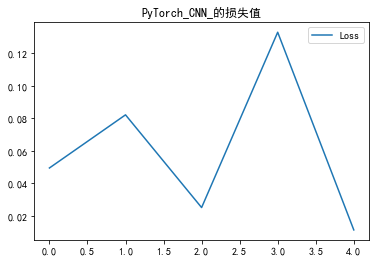

torch.Size([64, 1, 28, 28])


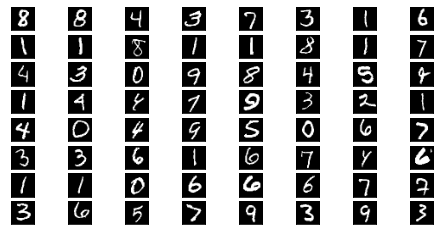

tensor([[-2.7580e+00, -3.5462e-02,  7.9680e+00,  1.5970e+00, -7.8789e+00,
         -1.8947e+00, -7.5621e-01, -4.0064e+00,  1.5878e+01, -4.7916e+00],
        [-1.8895e+00, -4.4768e+00,  3.8737e+00,  4.1609e+00, -5.8929e+00,
         -1.1182e+00, -3.6293e-01, -6.6656e+00,  1.4528e+01, -1.7961e+00],
        [-6.6220e+00,  1.7320e+00, -3.2843e+00, -4.2457e+00,  1.8390e+01,
          3.7761e-01, -9.4522e+00,  3.2909e+00, -3.2475e+00,  6.1151e+00],
        [-3.4585e+00, -3.2082e-01, -1.5872e+00,  1.3244e+01, -7.2396e+00,
          3.3917e+00, -7.9838e+00, -7.9507e-01,  1.7166e+00,  5.6055e+00],
        [ 1.5871e-01,  1.1681e+00,  3.9117e+00,  4.8113e+00, -6.6614e+00,
         -1.6805e+00, -1.1539e+01,  1.5123e+01, -2.9589e+00,  4.6857e-01],
        [-5.6980e+00,  2.5200e-01, -1.5851e+00,  1.6430e+01, -5.3405e+00,
          3.6573e+00, -8.3175e+00,  8.9490e-01, -7.1709e-01,  1.8055e+00],
        [-3.2109e+00,  1.1863e+01,  1.9506e+00, -9.6661e-02,  1.6265e+00,
         -3.5041e-01, -2.4757e+0

In [15]:

def show_image(x):
    """
    展示特征图
    :param x:
    :return:
    """
    print(x.shape)
    fig, axes = plt.subplots(8, 8, figsize=(8, 4), subplot_kw={"xticks": [], "yticks": []})
    for i, ax in enumerate(axes.flat):
        temp = x[i, 0].numpy()
        temp = temp.reshape(28, 28)
        temp = temp.clip(0, 255)
        ax.imshow(np.rint(temp).astype('uint8'), cmap="gray")
    # np.rint()是根据四舍五入取整,因为图片的值是整形的，矩阵求出的值是浮点型
    plt.axis('on')  # 关掉坐标轴为 off
    plt.show()


def test():
    # 获取测试集
    accuracy_sum = []
    test_loader = get_dataloader(False)
    for index, (a, b) in enumerate(test_loader):
        test_x = Variable(a)
        test_y = Variable(b)
        out = model(test_x)
        accuracy = torch.max(out, 1)[1].numpy() == test_y.numpy()
        accuracy_sum.append(accuracy.mean())
        if index % 100 == 0:
            print('测试了100批次准确率为:\t', accuracy.mean())

    print('总准确率：\t', sum(accuracy_sum) / len(accuracy_sum))
    # 精确率图
    # print('总准确率：\t', sum(accuracy_sum) / len(accuracy_sum))
    plt.figure('Accuracy')
    print(accuracy_sum)
    plt.plot(range(len(accuracy_sum)), accuracy_sum, 'o', label='accuracy')
    plt.title('Pytorch_CNN_准确率')
    plt.legend()
    plt.show()


# 先训练一次
# train(0)
#
# test_loader = get_dataloader(False)
#
# for index, (a, b) in enumerate(test_loader):
#     test_x = Variable(a)
#     test_y = Variable(b)
#     show_image(test_x)
#     out = model(test_x)
#     print(out)
#     print(torch.max(out, 1)[1].numpy())
#     break
# 进行测试和训练
for epoch in range(3):
    train(epoch)
    test()